## This is a showcase of usage of ART - a package inspired by Andrej Karpathy's blogpost.

### In this tutorial, you will be presented with how to use ART to perform very popular form of model training - the transfer learning, while following steps recommended by Andrej Karpathy.

Let's start with the dataset. Since ART is based on Pytorch-Lightning, we need to create LightningDataModule.\
For this tutorial, I decided to use very well known dataset called Cifar100 and I wrapped it into LightningDataModule creating [CifarDataModule](https://github.com/SebChw/ART-Templates/blob/cv_transfer_learning_tutorial/%7B%7Bcookiecutter.project_slug%7D%7D/MyDataset.py)

Okay, we have datamodule, but how do we use it?\
Let me introduce you, to the core of ART, the ArtProject.

In [1]:
from MyDataset import CifarDataModule
from art.project import ArtProject
project_name = "Cifar100"
dataset = CifarDataModule(batch_size=32)
project = ArtProject(project_name, dataset)

Now, that we have a Datamodule and ArtProject let's perform a first step: \
`Become one with the data`


To achieve this, we'll perform some data analysis.\
Firstly, create a new step for our project - Data analysis\
Here is how it could look like: [Data analysis step](https://github.com/SebChw/ART-Templates/blob/4c10a65fa8f7356933105ce78b694cbcbed3b6d0/%7B%7Bcookiecutter.project_slug%7D%7D/steps.py#L9)

In this class, we check multiple characteristics of the data:
* Number of classes
* Names of calsses
* Whether dataset is balanced - number of examples in each class
* The dimentions of images
* We get to know the actual visaluzations of the images (10 visualizations per class)

Let's insert it into the ArtProject

In [2]:
from checks import CheckClassImagesExist, CheckLenClassNamesEqualToNumClasses
from steps import DataAnalysis
from art.checks import CheckResultExists
project.add_step(DataAnalysis(), [
    CheckResultExists("number_of_classes"),
    CheckResultExists("class_names"),
    CheckResultExists("number_of_examples_in_each_class"),
    CheckResultExists("img_dimensions"),
    CheckClassImagesExist(),
    CheckLenClassNamesEqualToNumClasses()])
project.run_all()


Summary: 
Step: Data analysis, Model: , Passed: True. Results:



You can see, that except for the data analysis step, there are some checks.\
Those checks, are run after the step, so that we can be sure, that everything went as planned.\
`You`, as the user of ART, are responsible for creating checks that will suit your experiments.\
We used only two `custom` [checks](https://github.com/SebChw/ART-Templates/blob/cv_transfer_learning_tutorial/%7B%7Bcookiecutter.project_slug%7D%7D/checks.py) and one universal check implemented into art [CheckResultExists](https://github.com/SebChw/Actually-Robust-Training/blob/main/art/checks.py#L82).


Let's see the results:

Number of classes:  100
All classes names:  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'cra', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 't

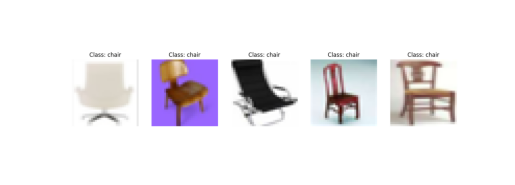

art_checkpoints\Data analysis\class_images\class_lizard.png


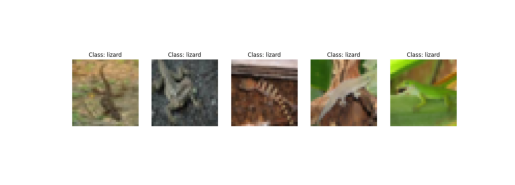

art_checkpoints\Data analysis\class_images\class_bee.png


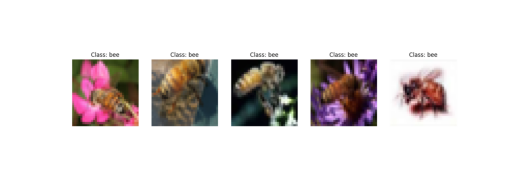

In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from os.path import normpath
results = project.get_step(0).get_latest_run()
print("Number of classes: ", results["number_of_classes"])
print("All classes names: ", results["class_names"])
print("Number of examples in each class: ", results["number_of_examples_in_each_class"])
print("Demansions of images: ", results["img_dimensions"])
for i in range(3):
    img_class = results["class_names"][random.randint(0, 100)]
    img_path = normpath(f"art_checkpoints/Data analysis/{project.get_step(0).get_class_image_path(img_class)}")
    print(img_path)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    


We can see, that the dataset is perfectly balanced, and indeed has 100 classes as it's name suggests.

Now that we know something about our dataset, we can proceed to the next steps. It is time to decide, what `metrics` will we use in our project.

In [4]:
from torchmetrics import Accuracy
import torch.nn as nn
from art.steps import EvaluateBaseline

NUM_CLASSES = project.get_step(0).get_latest_run()["number_of_classes"]
accuracy_metric, ce_loss = Accuracy(task="multiclass", num_classes = NUM_CLASSES), nn.CrossEntropyLoss()
# Register metrics, that you want to be calculated for every model that you will be using
project.register_metrics([accuracy_metric, ce_loss])

Having registered the metrics, we can proceed to the next step which is `Add baselines`. We want to make sure, that everything we did until this moment, works as it sholud, and there are no bugs in our DataLoader.\
This we used three [baselines](https://github.com/SebChw/ART-Templates/blob/cv_transfer_learning_tutorial/%7B%7Bcookiecutter.project_slug%7D%7D/models/baselines.py).\
Feel free to implement yours however you like, but remember to follow the structure of ArtModule.

In [5]:
from art.metrics import SkippedMetric
from models.baselines import MlBaseline, HeuristicBaseline, AlreadyExistingResNet20Baseline
from art.checks import CheckScoreExists
baselines = [HeuristicBaseline, MlBaseline, AlreadyExistingResNet20Baseline]
for baseline in baselines:
    project.add_step(
        step = EvaluateBaseline(baseline), 
        checks = [CheckScoreExists(metric=accuracy_metric)],
        skipped_metrics=[SkippedMetric(metric=ce_loss)]
    )


In [6]:
project.run_all()

Summary: 
Step: Data analysis, Model: , Passed: True. Results:

Step: Evaluate Baseline, Model: HeuristicBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.012299999594688416
Step: Evaluate Baseline, Model: MlBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.15649999678134918
Step: Evaluate Baseline, Model: AlreadyExistingResNet20Baseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.6883000135421753


Nice, we can see that MLBaseline is better than random selection, and that pretrained ResNet20 performs quite well.

Now, that we are sure, that our pipeline works as intended, we can start implementing our model.\
We will start with yet another good pracitce which is `check loss on init` - we want to make sure, that our model, which didn't see any of the Cifar100 data, will give us `loss` equal to `-log(1/100)`.

In [7]:
# from models.ResNet import ResNet
from models.EffiNet import EffiNet
from art.steps import CheckLossOnInit
from art.checks import CheckScoreCloseTo
import math

EXPECTED_LOSS = -math.log(1/NUM_CLASSES)
print(EXPECTED_LOSS)

4.605170185988091


We'll add new stop to the project `CheckLossOnInit`.

In [8]:
project.add_step(
        CheckLossOnInit(EffiNet),
        [CheckScoreCloseTo(metric=ce_loss,
                           value=EXPECTED_LOSS, rel_tol=0.1)]
    )

project.run_all()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Calculating loss on init
Validating model EfiNet


c:\Users\matri\anaconda3\envs\art\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
c:\Users\matri\anaconda3\envs\art\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

c:\Users\matri\anaconda3\envs\art\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Error while executing step Check Loss On Init!
Traceback (most recent call last):

  File "c:\Users\matri\anaconda3\envs\art\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
           │         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
           │         └ <code object <module> at 0x0000022AB3583050, file "c:\Users\matri\anaconda3\envs\art\lib\site-packages\ipykernel_launcher.py"...
           └ <function _run_code at 0x0000022AB358B400>

  File "c:\Users\matri\anaconda3\envs\art\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
         └ <code object <module> at 0x0000022AB3583050, file "c:\Users\matri\anaconda3\envs\art\lib\site-packages\ipykernel_launcher.py"...

  File "c:\Users\ma

c:\Users\matri\anaconda3\envs\art\lib\site-packages\lightning\pytorch\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


TypeError: 'NoneType' object is not subscriptable

Great, the loss looks good!\
The next step we want to perform, is to `overfit one batch` of our data. Thanks to this, we can be sure that our model is properly implemented.

In [ ]:
from art.steps import OverfitOneBatch
from art.checks import CheckScoreLessThan
project.add_step(OverfitOneBatch(EffiNet, number_of_steps=40),
            [CheckScoreLessThan(metric=ce_loss, value=0.05)])
project.run_all()

Summary: 
Step: Data analysis, Model: , Passed: True. Results:

Step: Evaluate Baseline, Model: HeuristicBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.012299999594688416
Step: Evaluate Baseline, Model: MlBaseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.15649999678134918
Step: Evaluate Baseline, Model: AlreadyExistingResNet20Baseline, Passed: True. Results:
	MulticlassAccuracy-validate: 0.6883000135421753
Step: Check Loss On Init, Model: ResNet18, Passed: True. Results:
	MulticlassAccuracy-validate: 0.015399999916553497
	CrossEntropyLoss-validate: 5.087794780731201
Step: Overfit One Batch, Model: ResNet18, Passed: True. Results:
	MulticlassAccuracy-train: 1.0
	CrossEntropyLoss-train: 0.00015361519763246179
Code of the following steps was changed: Data analysis, ResNet18_Check Loss On Init, ResNet18_Overfit One Batch
 Rerun could be needed.


And we will do the same, for the whole dataset.

In [ ]:
from art.steps import Overfit
from art.checks import CheckScoreGreaterThan

project.add_step(Overfit(EffiNet, max_epochs=10),
            [CheckScoreGreaterThan(metric=accuracy_metric, value=0.8)])

In [ ]:
project.run_all()

Now, that the model passed all steps and checks we can finaly proceed with the `transfer learning`!

In [ ]:
from art.steps import TransferLearning
from art.loggers import NeptuneLoggerAdapter
from lightning.pytorch.callbacks import EarlyStopping

logger = NeptuneLoggerAdapter(project="mmaecki/transfer-learning")
early_stopping = EarlyStopping('CrossEntropyLoss-validate', patience=6)
project.add_step(TransferLearning(EffiNet,
                                    freezed_trainer_kwargs={"max_epochs": 4,
                                                            "check_val_every_n_epoch": 2,
                                                            "callbacks": [early_stopping]},
                                    unfreezed_trainer_kwargs={"max_epochs": 50,
                                                            "check_val_every_n_epoch": 2,
                                                            "callbacks": [early_stopping]},
                                    keep_unfrozen=1,
                                    logger = logger,
                                    ),
                    [CheckScoreGreaterThan(metric=accuracy_metric, value=0.70)])

c:\Users\matri\anaconda3\envs\art\lib\site-packages\neptune\common\warnings.py:62: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  warnings.warn(


https://app.neptune.ai/mmaecki/transfer-learning/e/TRAN-5


In [ ]:
project.run_all()
logger.stop()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using cache found in C:\Users\matri/.cache\torch\hub\facebookresearch_semi-supervised-ImageNet1K-models_master
c:\Users\matri\anaconda3\envs\art\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matri\anaconda3\envs\art\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

  | Name  | Type             | Params
-------------------------------------------
0 | model | 

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\matri\anaconda3\envs\art\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\matri\anaconda3\envs\art\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are us

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
Communication with Neptune restored!


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\matri\anaconda3\envs\art\lib\site-packages\lightning\pytorch\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Using cache found in C:\Users\matri/.cache\torch\hub\facebookresearch_semi-supervised-ImageNet1K-models_master
c:\Users\matri\anaconda3\envs\art\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory c:\Users\matri\Polibuda\diploma\ART-Templates\{{cookiecutter.project_slug}}\.neptune\Untitled\TRAN-5\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropy

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]